In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy import stats
from sonnia.processing import Processing
from sonia.sonia_leftpos_rightpos import SoniaLeftposRightpos
import itertools
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.stats import ttest_ind
import itertools
from statsmodels.stats.multitest import multipletests
import umap
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
def hist(vals,bins,linestyle='-',label='',color=None):
    a,b= np.histogram(vals,bins)
    bin_centers = 0.5*(b[1:]+b[:-1])
    plt.plot(bin_centers,a/np.sum(a),linestyle=linestyle,label=label,color=color)
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
order=['gen','++','CD8+','Tconv','Treg']
names=[r'$P_{\rm gen}$','DP','CD8+','Tconv','Treg']
colors=['grey','darkorange','gold','darkgreen','lightblue']
palette=sns.color_palette()
colors=[palette[i] for i in [7,1,8,2,0]]
names_dict={'++':'DP', 'CD8+':'CD8+', 'Tconv':'Tconv', 'Treg':'Treg', 'gen':r'$P_{\rm gen}$'}
samples=['p2_gen', 'p2_++', 'p2_CD8+', 'p2_Treg', 'p2_Tconv', 'p22_gen','p22_++', 'p22_CD8+', 'p22_Treg', 'p22_Tconv', 'p23_gen', 'p23_++',
       'p23_CD8+', 'p23_Treg', 'p23_Tconv', 'p24_gen', 'p24_++','p24_CD8+', 'p24_Treg', 'p24_Tconv', 'p25_gen', 'p25_++',
       'p25_CD8+', 'p25_Treg', 'p25_Tconv', 'p26_gen', 'p26_++','p26_CD8+', 'p26_Treg', 'p26_Tconv', 'p27_gen', 'p27_++',
       'p27_CD8+', 'p27_Treg', 'p27_Tconv', 'p32_gen', 'p32_++','p32_CD8+', 'p32_Treg', 'p32_Tconv', 'p36_gen', 'p36_++',
       'p36_CD8+', 'p36_Treg', 'p36_Tconv']

In [3]:
matrix=pd.read_csv('results/dist_matrix_global.csv.gz')
samples=matrix.columns.values
patients=[s.split('_')[0] for s in samples]
cell_types=[s.split('_')[1] for s in samples]

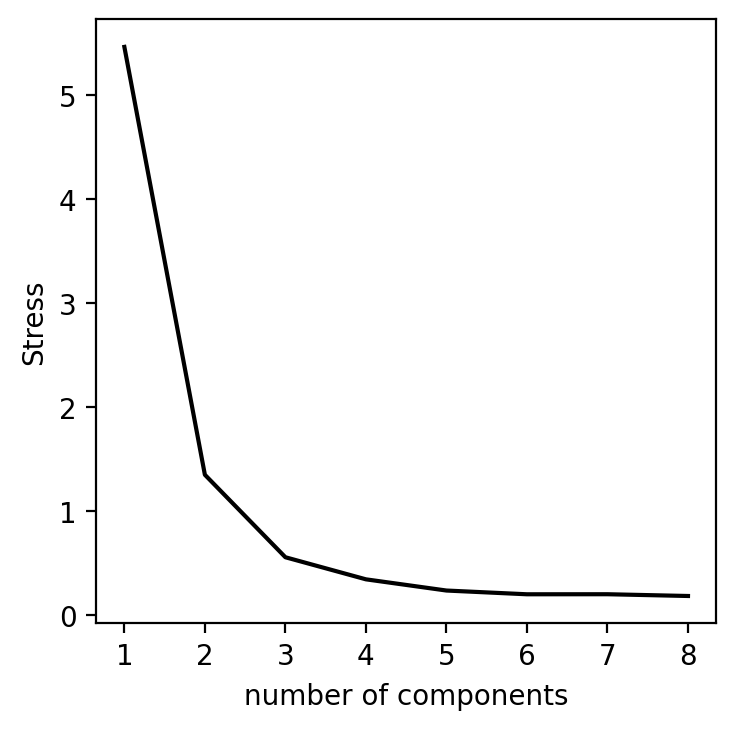

In [6]:
stresses=[]
s=[1,2,3,4,5,6,7,8]
for components in s:
    embedding = MDS(n_components=components,dissimilarity='precomputed',n_init=10)
    u0 = embedding.fit_transform(matrix.values)
    stresses.append(embedding.stress_)
plt.figure(figsize=(4,4),dpi=200)
plt.plot(s,stresses,c='k')
plt.xticks(s,s)
plt.xlabel('number of components')
plt.ylabel('Stress')
plt.show()

In [7]:
from scipy.spatial.transform import Rotation
from scipy.stats import pearsonr
subsets=[]
for cell in np.array(cell_types):
    subsets.append([cell in i for i in np.array(cell_types)])
map_cells={'gen':0,'++':1,'CD8+':2,'Treg':3,'Tconv':3}
scalar_cells=[map_cells[k] for k in cell_types]
order_patients=dict(zip(np.unique(patients),[4, 7, 5, 2, 1, 0, 6, 8, 3],))
scalar_patients=[order_patients[k] for k in patients]

In [8]:
from scipy.spatial.transform import Rotation
embedding = MDS(n_components=3,dissimilarity='precomputed',n_init=5,random_state=0)
u0 = embedding.fit_transform(matrix.values)
spearmans=[]
spearmans2=[]
for i in range(1000):
    r=Rotation.random(random_state=i)
    u1=r.apply(u0)
    spearmans.append(spearmanr(scalar_cells,u1[:,0])[0])
    spearmans2.append(pearsonr(u1[np.array(scalar_cells)==2,2][[4, 7, 5, 2, 1, 6, 0, 8, 3]],range(9))[0])
print(np.max(spearmans),np.max(spearmans2))

0.9471539889553559 0.9847614387348075


In [9]:
embedding = MDS(n_components=2,dissimilarity='precomputed',n_init=5,random_state=0)
u1 = embedding.fit_transform(matrix.values)

In [10]:
np.argmax(np.array(spearmans)+np.array(spearmans2)),np.argmax(spearmans),np.argmax(spearmans2)

(112, 112, 251)

In [11]:
r=Rotation.random(random_state=(112))
u1=r.apply(u0)

In [12]:
ptonum=dict(zip(np.unique(np.array(patients)),range(9)))
new_order=[ptonum[p] for p in ['p25','p32','p26','p23','p22','p27','p2','p36','p24']]
new_order

[4, 7, 5, 2, 1, 6, 0, 8, 3]

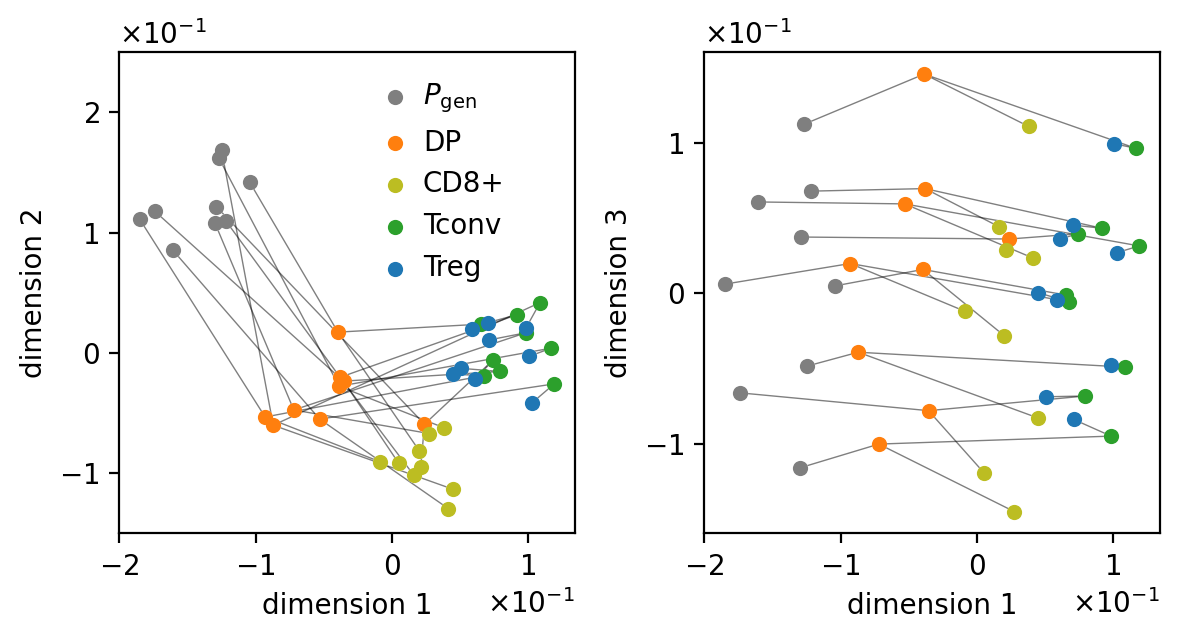

In [14]:
alpha=1
def plot_axis(ax0,ax1):
    plt.locator_params(nbins=4)
    for p in np.unique(np.array(patients)):
        embedded_patient=u1[np.array(patients)==p]
        for i in range(1):    
            plt.plot([embedded_patient[i,ax0],embedded_patient[i+1,ax0]],[embedded_patient[i,ax1],embedded_patient[i+1,ax1]],
                 c='k',linewidth=0.5,alpha=0.5,zorder=0)

        plt.plot([embedded_patient[1,ax0],embedded_patient[2,ax0]],[embedded_patient[1,ax1],embedded_patient[2,ax1]],
                 c='k',linewidth=0.5,alpha=0.5,zorder=0)
        plt.plot([embedded_patient[1,ax0],embedded_patient[3,ax0]],[embedded_patient[1,ax1],embedded_patient[3,ax1]],
                 c='k',linewidth=0.5,alpha=0.5,zorder=0)
        plt.plot([embedded_patient[3,ax0],embedded_patient[4,ax0]],[embedded_patient[3,ax1],embedded_patient[4,ax1]],
                 c='k',linewidth=0.5,alpha=0.5,zorder=0)
        
    for i in range(5):       
        plt.scatter(u1[subsets[i],ax0],u1[subsets[i],ax1],
                    c='w',alpha=1, linewidths=0,s=30)  
    for i in range(5):
        plt.scatter(u1[subsets[i],ax0],u1[subsets[i],ax1],
                    color=colors[i],label=names[i],alpha=alpha, linewidths=0,s=30)
    #for i,p in enumerate(np.unique(np.array(patients))):
    #        plt.text(u1[subsets[0],ax0][i],u1[subsets[0],ax1][i],p)
    plt.xlabel('dimension '+str(ax0+1))
    plt.ylabel('dimension '+str(ax1+1))
    if ax1==1:plt.ylim([-0.15,0.25])
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0),useMathText=True)
    
plt.figure(figsize=(6,3.3),dpi=200)
plt.subplot(121)
plot_axis(0,1)
plt.legend(frameon=False,bbox_to_anchor=(.49, 0.47),handletextpad=0.)
ax=plt.subplot(122)
plot_axis(0,2)
plt.tight_layout()
plt.show()

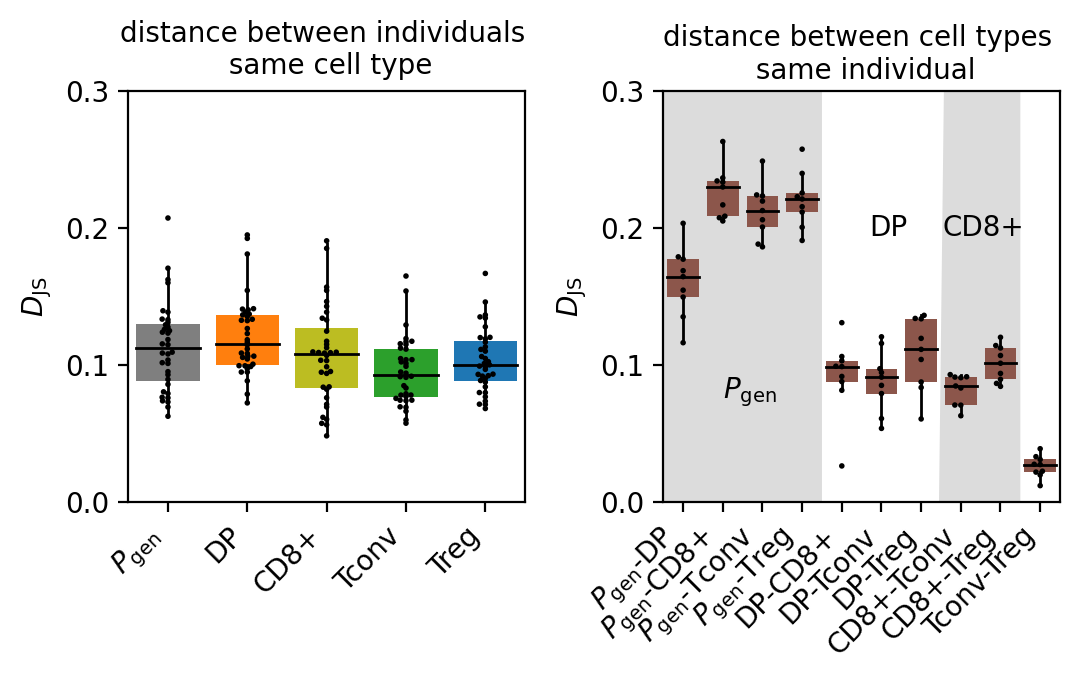

In [15]:
dist_matrix=matrix.values
inter_individuals=[]
values=[]
for j,cell in enumerate(['gen','++', 'CD8+', 'Tconv', 'Treg']):
    d=dist_matrix[np.array(cell_types)==cell][:,np.array(cell_types)==cell]
    inter_individuals.append(d[np.triu_indices(9,k=1)])
    values.append([names_dict[cell]]*len(d[np.triu_indices(9,k=1)]))
i=np.concatenate(inter_individuals)
j=np.concatenate(values)
data=pd.DataFrame(zip(i,j),columns=['DJS','cell_type'])

fig, ax = plt.subplots(figsize=(5.5,3.5),dpi=200)
ax=plt.subplot(121)
plt.locator_params(nbins=4)
c=colors
sns.boxplot(x="cell_type", y="DJS", data=data,order=names,palette=colors,linewidth=1,fliersize=0,width=0.8,saturation=1,boxprops={"linewidth": 0})
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, alpha))
for i,box in enumerate(ax.artists):
        # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        if j%6==2 or j%6==3:ax.lines[j].set_color('white')      
            
sns.swarmplot(x="cell_type", y="DJS", data=data,order=names,color='k',size=1,edgecolor='k',linewidth=1.,orient='v')
plt.xticks(np.arange(len(names)),names)
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel(r'$D_{\rm JS}$')
plt.ylim(0,0.3)
plt.xticks(rotation=45,ha="right")

inter_individuals=[]
values=[]
cell_subsets_to_do=['gen','++', 'CD8+', 'Tconv', 'Treg']

pairs=list(itertools.combinations(np.arange(len(cell_subsets_to_do)),2))
for j,(cell1,cell2) in enumerate(pairs):
    d=dist_matrix[np.array(cell_types)==cell_subsets_to_do[cell1]][:,np.array(cell_types)==cell_subsets_to_do[cell2]]
    inter_individuals.append(np.diagonal(d))

    values.append([names_dict[cell_subsets_to_do[cell1]]+'-'+ names_dict[cell_subsets_to_do[cell2]]]*9)
i=np.concatenate(inter_individuals)
j=np.concatenate(values)
data=pd.DataFrame(zip(i,j),columns=['DJS','cell_type'])
plt.title('distance between individuals \n same cell type',fontsize=10)

ax=plt.subplot(122)

plt.locator_params(nbins=4)
sns.boxplot(x="cell_type", y="DJS", data=data,color=palette[5],linewidth=1,fliersize=0,width=0.8,saturation=1,boxprops={"linewidth": 0})
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, alpha))
sns.swarmplot(x="cell_type", y="DJS", data=data,color='k',size=1,edgecolor='k',linewidth=1.,orient='v')
for i,box in enumerate(ax.artists):
        # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        if j%6==2 or j%6==3:ax.lines[j].set_alpha(0)

plt.tight_layout()
plt.xlabel('')
plt.ylabel(r'$D_{\rm JS}$')
plt.xticks(rotation=45,ha="right")
plt.ylim(0,0.3)
plt.tight_layout()
plt.title('distance between cell types \n same individual',fontsize=10,rotation_mode="anchor")
plt.fill_between([-1,3.5],[0,5],facecolor='gainsboro', alpha=1,zorder=-1,linewidth=0)
plt.fill_between([6.45,8.5],[0,5],facecolor='gainsboro', alpha=1,zorder=-1,linewidth=0)
plt.text(1.,0.08,r'$P_{\rm gen}$',verticalalignment='center')
plt.text(4.7,0.2,r'DP',verticalalignment='center')
plt.text(6.55,0.2,r'CD8+',verticalalignment='center')

plt.show()

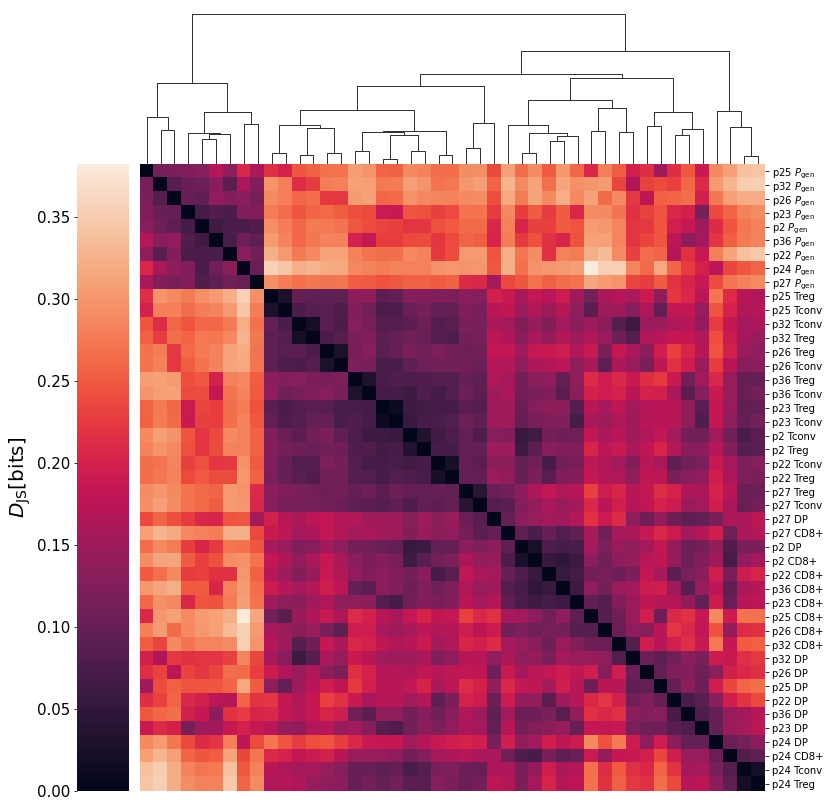

In [17]:
columns=[' '.join([d.split('_')[0],names_dict[d.split('_')[1]]]) for d in matrix.columns]
linkage = hc.linkage(sp.distance.squareform(matrix.values), method='complete', optimal_ordering=True)
my_df=matrix.copy()
my_df.index= columns
my_df.columns=columns
g=sns.clustermap(my_df,cbar_kws={'label': r'$D_{\rm JS} {\rm [bits]}$'},figsize=(12,12),row_linkage=linkage, col_linkage=linkage)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
g.ax_heatmap.xaxis.set_visible(False)
g.cax.figure.axes[-1].yaxis.label.set_size(20)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)
g.ax_row_dendrogram.set_visible(False)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 10)
g.cax.yaxis.set_ticks_position("left")
g.cax.yaxis.set_label_position('left')
dendro_box = g.ax_row_dendrogram.get_position()
dendro_box.x0 = (dendro_box.x0 + 2 * dendro_box.x1) / 3 -0.01
dendro_box.x1=dendro_box.x1-0.01
g.cax.set_position(dendro_box)
plt.show()